# Animal Adoption Prediction Model Training
This notebook trains a machine learning model to predict animal adoption outcomes using the insights from our data exploration.

## Cell 1: Setup and Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style for better visualizations
plt.style.use('default')
sns.set_palette("husl")
print("✅ Dependencies imported successfully")

✅ Dependencies imported successfully


## Cell 2: Configuration and Initialization

In [ ]:
# Configuration and Model Loading
import json
import os
from pathlib import Path

import boto3
try:
    import sagemaker
except ImportError:
    sagemaker = None

def load_config():
    """Load configuration with multiple fallback options"""
    # Option 1: Load from config.json (recommended)
    config_file = Path('./config.json')
    if config_file.exists():
        with open(config_file) as f:
            config = json.load(f)
        print(f"Configuration loaded from {config_file}")
        return config
    
    # Option 2: Try environment variables
    if os.environ.get('S3_BUCKET_NAME'):
        config = {
            's3_bucket_name': os.environ['S3_BUCKET_NAME'],
            'aws_region': os.environ.get('AWS_REGION', 'us-east-1'),
            'sagemaker_role_arn': os.environ.get('SAGEMAKER_ROLE_ARN', '')
        }
        print("Configuration loaded from environment variables")
        return config
    
    # Option 3: Interactive input (beginner-friendly fallback)
    print("Configuration not found. Let's set it up interactively.")
    print("(You can skip this by running: python config_generator.py)")
    
    config = {}
    bucket_name = input("Enter your S3 bucket name (from terraform output): ").strip()
    config['s3_bucket_name'] = bucket_name
    config['aws_region'] = 'us-east-1'
    
    # For deployment notebook, SageMaker role is more important
    sagemaker_role = input("Enter SageMaker role ARN (required for deployment): ").strip()
    if sagemaker_role:
        config['sagemaker_role_arn'] = sagemaker_role
    
    # Save for next time
    with open('./config.json', 'w') as f:
        json.dump(config, f, indent=2)
    print("Configuration saved to config.json for future use")
    return config

# Load configuration
try:
    config = load_config()
    BUCKET_NAME = config['s3_bucket_name']
    AWS_REGION = config.get('aws_region', 'us-east-1')
    SAGEMAKER_ROLE = config.get('sagemaker_role_arn', None)
    
    print(f"Using S3 bucket: {BUCKET_NAME}")
    print(f"Using AWS region: {AWS_REGION}")
    
    if SAGEMAKER_ROLE:
        print(f"SageMaker role: {SAGEMAKER_ROLE[:50]}...")
        if sagemaker is None:
            print("SageMaker package not available")
            sagemaker_session = None
        else:
            boto_sess = boto3.Session(region_name=AWS_REGION)
            sagemaker_session = sagemaker.Session(boto_session=boto_sess)
            print(f"SageMaker session initialized in {AWS_REGION} - deployment enabled")
    else:
        print("No SageMaker role configured - local testing only")
        sagemaker_session = None

except KeyboardInterrupt:
    print("Configuration cancelled. Please run this cell again when ready.")
    BUCKET_NAME = None
    AWS_REGION = 'us-east-1'
    SAGEMAKER_ROLE = None
    sagemaker_session = None

Configuration loaded from config.json
Using S3 bucket: animal-insights-ae1a1bd9
Using AWS region: us-east-1
SageMaker role: arn:aws:iam::239285815587:role/sagemaker-execution...
SageMaker session initialized in us-east-1 - deployment enabled


## Cell 3: Data Loading Function

In [26]:
def prepare_data():
    """Load and prepare data from processed file, S3, or raw data"""
    # Try multiple data sources in order of preference
    
    # 1. Try processed data from data exploration notebook
    try:
        df = pd.read_csv('./data/processed_animal_data.csv')
        print(f"✅ Loaded processed data from file: {len(df):,} records")
        return df
    except FileNotFoundError:
        print("No processed data file found, trying other sources...")
    
    # 2. Try raw data from local file
    try:
        print("Loading raw data from local file...")
        df = pd.read_csv('./data/austin_animal_outcomes.csv')
        print(f"✅ Loaded raw data from file: {len(df):,} records")
        
        # Add age in days if not present
        if 'age_in_days' not in df.columns:
            print("Converting age to days...")
            df['age_in_days'] = df['Age upon Outcome'].apply(parse_age_in_days)
            
        # Add time features
        print("Adding time features...")
        df['DateTime'] = pd.to_datetime(df['DateTime'])
        df['outcome_month'] = df['DateTime'].dt.month
        df['outcome_hour'] = df['DateTime'].dt.hour
        
        return df
        
    except FileNotFoundError:
        print("No local data file found, trying S3...")
    
    # 3. Try S3 as last resort (if bucket is configured)
    if BUCKET_NAME:
        try:
            print(f"Attempting to load from S3 bucket: {BUCKET_NAME}")
            s3 = boto3.client('s3')
            
            # List available files in the bucket
            try:
                response = s3.list_objects_v2(Bucket=BUCKET_NAME, Prefix='raw/')
                if 'Contents' in response:
                    print("Available files in S3:")
                    for obj in response['Contents']:
                        print(f"  - {obj['Key']}")
                    
                    # Try to find a CSV file
                    csv_files = [obj['Key'] for obj in response['Contents'] if obj['Key'].endswith('.csv')]
                    if csv_files:
                        key = csv_files[0]  # Use the first CSV file found
                        print(f"Loading from S3: {key}")
                        obj = s3.get_object(Bucket=BUCKET_NAME, Key=key)
                        df = pd.read_csv(obj['Body'])
                        print(f"✅ Loaded data from S3: {len(df):,} records")
                        
                        # Add age in days if not present
                        if 'age_in_days' not in df.columns:
                            print("Converting age to days...")
                            df['age_in_days'] = df['Age upon Outcome'].apply(parse_age_in_days)
                            
                        # Add time features
                        print("Adding time features...")
                        df['DateTime'] = pd.to_datetime(df['DateTime'])
                        df['outcome_month'] = df['DateTime'].dt.month
                        df['outcome_hour'] = df['DateTime'].dt.hour
                        
                        return df
                else:
                    print("No files found in S3 bucket")
            except Exception as e:
                print(f"Error listing S3 objects: {e}")
                
        except Exception as e:
            print(f"Failed to load from S3: {e}")
    else:
        print("No S3 bucket configured, skipping S3 check")
    
    # 4. If all else fails, provide instructions
    raise FileNotFoundError(
        "❌ Could not find data in any location!\n"
        "Please ensure you have one of:\n"
        "1. Run the data exploration notebook first to create processed_animal_data.csv\n"
        "2. Place austin_animal_outcomes.csv in the ./data/ directory\n"
        "3. Upload data to your S3 bucket in the raw/ folder"
    )

def parse_age_in_days(age_str):
    """Convert age strings to days"""
    if pd.isna(age_str):
        return np.nan
    
    age_str = str(age_str).lower().strip()
    
    try:
        if 'year' in age_str:
            return float(age_str.split()[0]) * 365
        elif 'month' in age_str:
            return float(age_str.split()[0]) * 30
        elif 'week' in age_str:
            return float(age_str.split()[0]) * 7
        elif 'day' in age_str:
            return float(age_str.split()[0])
        else:
            return np.nan
    except (ValueError, IndexError):
        return np.nan

# Load the data
print("Looking for data sources...")
df = prepare_data()

# Display basic info about the dataset
print(f"\nDataset Overview:")
print(f"Dataset shape: {df.shape}")
if 'Outcome Type' in df.columns:
    print(f"Outcome types: {df['Outcome Type'].value_counts().to_dict()}")
else:
    print("Available columns:", list(df.columns))

Looking for data sources...
✅ Loaded processed data from file: 173,775 records

Dataset Overview:
Dataset shape: (173775, 17)
Outcome types: {'Adoption': 84598, 'Transfer': 48689, 'Return to Owner': 25691, 'Euthanasia': 10833, 'Died': 1672, 'Rto-Adopt': 1241, 'Disposal': 877, 'Missing': 92, 'Relocate': 29, 'Stolen': 5, 'Lost': 2}


/var/folders/40/z966pbpx74b58k49j23j3mxr0000gp/T/ipykernel_54624/3425447467.py:7: DtypeWarning: Columns (3,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/processed_animal_data.csv')


## Cell 4: Data Preprocessing Function

In [27]:
def preprocess_features(df):
    """Preprocess features for training"""
    # Create a copy to avoid modifying original
    df_processed = df.copy()
    
    # Define categorical columns that need special handling
    categorical_columns = ['Animal Type', 'Sex upon Outcome', 'Breed', 'Color']
    
    # Process each categorical column
    for col in categorical_columns:
        if col in df_processed.columns:
            # Fill missing values with 'unknown'
            df_processed[col] = df_processed[col].fillna('unknown')
            
            # Create simplified column name for ML
            simple_name = col.lower().replace(' ', '_').replace('upon_', '')
            
            # For breed, extract primary breed (first word)
            if col == 'Breed':
                df_processed['primary_breed'] = df_processed[col].str.split().str[0]
                # Limit to top 20 breeds to prevent overfitting
                top_breeds = df_processed['primary_breed'].value_counts().head(20).index
                df_processed['primary_breed'] = df_processed['primary_breed'].apply(
                    lambda x: x if x in top_breeds else 'other'
                )
            else:
                df_processed[simple_name] = df_processed[col]
                # Limit to top categories for other fields too
                if col != 'Animal Type':  # Keep all animal types
                    top_categories = df_processed[simple_name].value_counts().head(20).index
                    df_processed[simple_name] = df_processed[simple_name].apply(
                        lambda x: x if x in top_categories else 'other'
                    )
    
    # Handle missing numerical values
    if 'age_in_days' in df_processed.columns:
        df_processed['age_in_days'] = df_processed['age_in_days'].fillna(
            df_processed['age_in_days'].median()
        )
    
    # Add time features if DateTime exists
    if 'DateTime' in df_processed.columns:
        df_processed['DateTime'] = pd.to_datetime(df_processed['DateTime'])
        if 'outcome_month' not in df_processed.columns:
            df_processed['outcome_month'] = df_processed['DateTime'].dt.month
        if 'outcome_hour' not in df_processed.columns:
            df_processed['outcome_hour'] = df_processed['DateTime'].dt.hour
    
    # Create binary target: 1 for Adoption, 0 for others
    df_processed['adopted_label'] = (df_processed['Outcome Type'] == 'Adoption').astype(int)
    
    print(f"✅ Preprocessing complete. Binary adoption rate: {df_processed['adopted_label'].mean():.3f}")
    
    return df_processed

# Preprocess the data
df_processed = preprocess_features(df)
print(f"Processed dataset shape: {df_processed.shape}")

✅ Preprocessing complete. Binary adoption rate: 0.487
Processed dataset shape: (173775, 24)


## Cell 5: Model Training Function

In [28]:
def train_model():
    """Main training function"""
    
    # Define features for training
    feature_columns = ['animal_type', 'sex_outcome', 'age_in_days', 'primary_breed', 'color', 'outcome_month']
    
    # Check which features exist
    available_features = [col for col in feature_columns if col in df_processed.columns]
    print(f"Available features: {available_features}")
    
    # Use available features
    X = df_processed[available_features]
    y = df_processed['adopted_label']  # Target: 1 = adopted, 0 = not adopted
    
    # Split data for training and validation
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Training set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    print(f"Training adoption rate: {y_train.mean():.3f}")
    print(f"Test adoption rate: {y_test.mean():.3f}")
    
    return X_train, X_test, y_train, y_test

# Split the data
X_train, X_test, y_train, y_test = train_model()

Available features: ['animal_type', 'sex_outcome', 'age_in_days', 'primary_breed', 'color', 'outcome_month']
Training set size: 139020
Test set size: 34755
Training adoption rate: 0.487
Test adoption rate: 0.487


## Cell 6: Feature Encoding

In [29]:
def encode_features(X_train, X_test):
    """Convert categorical text data to numbers for machine learning"""
    # Create copies to avoid modifying originals
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()
    
    # Store encoders for later use
    label_encoders = {}
    
    # Encode categorical features
    for column in X_train_encoded.columns:
        if X_train_encoded[column].dtype == 'object':
            print(f"Encoding {column}...")
            
            # Create and fit encoder on training data
            encoder = LabelEncoder()
            X_train_encoded[column] = encoder.fit_transform(X_train_encoded[column].astype(str))
            
            # Apply to test data, handling unseen categories
            test_values = X_test_encoded[column].astype(str)
            # Map unseen categories to 'unknown' if it exists, otherwise to the most common class
            unseen_mask = ~test_values.isin(encoder.classes_)
            if unseen_mask.any():
                print(f"  Found {unseen_mask.sum()} unseen categories in {column}")
                if 'unknown' in encoder.classes_:
                    test_values[unseen_mask] = 'unknown'
                else:
                    # Use most common class
                    most_common = X_train[column].mode().iloc[0]
                    test_values[unseen_mask] = most_common
            
            X_test_encoded[column] = encoder.transform(test_values)
            label_encoders[column] = encoder
            
            print(f"  {column}: {len(encoder.classes_)} unique values")
    
    return X_train_encoded, X_test_encoded, label_encoders

# Encode features
X_train_encoded, X_test_encoded, label_encoders = encode_features(X_train, X_test)
print(f"\n✅ Feature encoding complete!")
print(f"Training features shape: {X_train_encoded.shape}")
print(f"Test features shape: {X_test_encoded.shape}")

Encoding animal_type...
  animal_type: 5 unique values
Encoding sex_outcome...
  Found 1 unseen categories in sex_outcome
  sex_outcome: 5 unique values
Encoding primary_breed...
  primary_breed: 21 unique values
Encoding color...
  color: 21 unique values

✅ Feature encoding complete!
Training features shape: (139020, 6)
Test features shape: (34755, 6)


## Cell 7: Model Training and Evaluation

Training with: 1.2.1
Training Random Forest model...

📊 Model Performance:
Accuracy: 0.797

📋 Detailed Classification Report:
              precision    recall  f1-score   support

 Not Adopted       0.85      0.74      0.79     17835
     Adopted       0.76      0.86      0.81     16920

    accuracy                           0.80     34755
   macro avg       0.80      0.80      0.80     34755
weighted avg       0.80      0.80      0.80     34755


🔍 Top 10 Most Important Features:
  sex_outcome: 0.607
  age_in_days: 0.285
  animal_type: 0.071
  primary_breed: 0.023
  outcome_month: 0.009
  color: 0.005


<Figure size 1000x600 with 0 Axes>

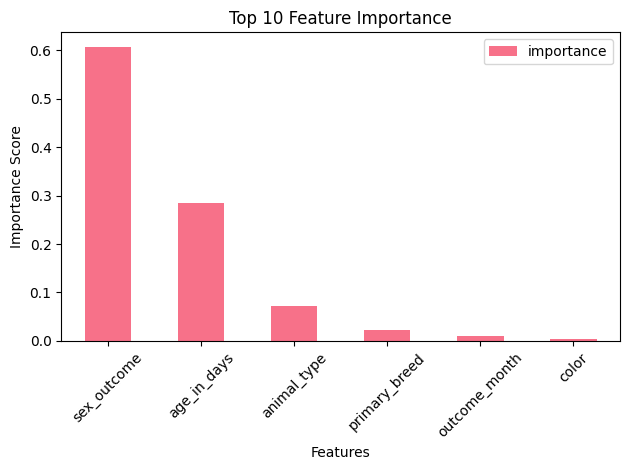

In [ ]:
from sklearn.impute import SimpleImputer
import sklearn

def train_and_evaluate(X_train, X_test, y_train, y_test):
    """Impute missing values, train the Random Forest model, and evaluate performance."""
    print("Training Random Forest model...")

    # Impute any remaining NaNs before fitting
    # Numeric columns -> median; Categorical/object columns (if any) -> most_frequent
    X_train_imp = X_train.copy()
    X_test_imp = X_test.copy()

    num_cols = X_train_imp.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in X_train_imp.columns if c not in num_cols]

    if num_cols:
        num_imputer = SimpleImputer(strategy="median")
        X_train_imp[num_cols] = num_imputer.fit_transform(X_train_imp[num_cols])
        X_test_imp[num_cols] = num_imputer.transform(X_test_imp[num_cols])

    if cat_cols:
        cat_imputer = SimpleImputer(strategy="most_frequent")
        X_train_imp[cat_cols] = cat_imputer.fit_transform(X_train_imp[cat_cols])
        X_test_imp[cat_cols] = cat_imputer.transform(X_test_imp[cat_cols])

    # Sanity check
    if X_train_imp.isna().any().any() or X_test_imp.isna().any().any():
        raise ValueError("Imputation failed: still seeing NaNs after imputers.")

    # -------------------------------------------------------

    # Create and train the model
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1  
    )

    model.fit(X_train_imp, y_train)

    # Make predictions
    y_pred = model.predict(X_test_imp)

    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n📊 Model Performance:")
    print(f"Accuracy: {accuracy:.3f}")

    print(f"\n📋 Detailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Not Adopted', 'Adopted']))

    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train_imp.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\n🔍 Top 10 Most Important Features:")
    for _, row in feature_importance.head(10).iterrows():
        print(f"  {row['feature']}: {row['importance']:.3f}")

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    feature_importance.head(10).plot(x='feature', y='importance', kind='bar')
    plt.title('Top 10 Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return model

print("Training with:", sklearn.__version__)
assert sklearn.__version__.startswith("1.2."), "Please install scikit-learn==1.2.1 to match the serving image"

# Train and evaluate the model
model = train_and_evaluate(X_train_encoded, X_test_encoded, y_train, y_test)

## Cell 8: Save Model and Encoders

In [31]:
def save_model_artifacts():
    """Save the trained model and encoders for later use"""
    
    # Create models directory if it doesn't exist
    os.makedirs('./models', exist_ok=True)
    
    # Save the trained model
    model_path = './models/animal_adoption_model.pkl'
    joblib.dump(model, model_path)
    print(f"✅ Model saved to {model_path}")
    
    # Save the label encoders
    encoders_path = './models/label_encoders.pkl'
    joblib.dump(label_encoders, encoders_path)
    print(f"✅ Encoders saved to {encoders_path}")
    
    # Save feature names for reference
    feature_info = {
        'feature_names': list(X_train_encoded.columns),
        'n_features': len(X_train_encoded.columns),
        'target_name': 'adopted_label'
    }
    
    import json
    with open('./models/model_info.json', 'w') as f:
        json.dump(feature_info, f, indent=2)
    print(f"✅ Model info saved to ./models/model_info.json")
    
    print(f"\nModel training completed and artifacts saved!")
    
    return model_path, encoders_path

# Save all artifacts
model_path, encoders_path = save_model_artifacts()

print("\nTraining Summary:")
print(f"Model type: Random Forest Classifier")
print(f"Features used: {len(X_train_encoded.columns)}")
print(f"Training samples: {len(X_train_encoded)}")
print(f"Test samples: {len(X_test_encoded)}")
print(f"Model saved to: {model_path}")
print(f"Encoders saved to: {encoders_path}")

✅ Model saved to ./models/animal_adoption_model.pkl
✅ Encoders saved to ./models/label_encoders.pkl
✅ Model info saved to ./models/model_info.json

Model training completed and artifacts saved!

Training Summary:
Model type: Random Forest Classifier
Features used: 6
Training samples: 139020
Test samples: 34755
Model saved to: ./models/animal_adoption_model.pkl
Encoders saved to: ./models/label_encoders.pkl


## Cell 9: Test Model Loading (Verification)

In [32]:
from sklearn.impute import SimpleImputer

print("🔍 Testing saved model loading...")

# Load the model & encoders
loaded_model = joblib.load(model_path)
loaded_encoders = joblib.load(encoders_path)

# Build a small test frame
X_test_sample = X_test_encoded.iloc[:5].copy()

# --- Impute like Cell 7 ---
num_cols = X_test_sample.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_test_sample.columns if c not in num_cols]

if num_cols:
    num_imputer = SimpleImputer(strategy="median")
    # Fit on the full X_train_encoded (same distribution used at training time)
    num_imputer.fit(X_train_encoded[num_cols])
    X_test_sample[num_cols] = num_imputer.transform(X_test_sample[num_cols])

if cat_cols:
    cat_imputer = SimpleImputer(strategy="most_frequent")
    cat_imputer.fit(X_train_encoded[cat_cols])
    X_test_sample[cat_cols] = cat_imputer.transform(X_test_sample[cat_cols])

# Sanity check
assert not X_test_sample.isna().any().any(), "Still seeing NaNs after imputation."

# Predict
test_predictions = loaded_model.predict(X_test_sample)
test_probabilities = loaded_model.predict_proba(X_test_sample)[:, 1]

print("✅ Model loaded successfully!")
print(f"Test predictions: {test_predictions}")
print(f"Test probabilities: {test_probabilities.round(3)}")
print(f"Actual values: {y_test.iloc[:5].values}")

print("\n🎉 ML Training Pipeline Complete!")
print("Ready for model deployment to SageMaker.")

🔍 Testing saved model loading...
✅ Model loaded successfully!
Test predictions: [0 0 1 1 0]
Test probabilities: [0.074 0.439 0.633 0.943 0.41 ]
Actual values: [0 1 0 1 1]

🎉 ML Training Pipeline Complete!
Ready for model deployment to SageMaker.
